（1）Scrape the data and save it as a table.

In [1]:
from __future__ import annotations

import time
from datetime import datetime
from io import StringIO
from pathlib import Path

import pandas as pd
import requests


URL_0_3Y = (
    "https://markets.businessinsider.com/bonds/finder?"
    "borrower=71&maturity=shortterm&yield=&bondtype=2%2C3%2C4%2C16"
    "&coupon=&currency=184&rating=&country=19"
)

URL_3_10Y = (
    "https://markets.businessinsider.com/bonds/finder?"
    "borrower=71&maturity=midterm&yield=&bondtype=2%2C3%2C4%2C16"
    "&coupon=&currency=184&rating=&country=19"
)

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36"
    )
}


# Resolve the script directory.
def script_dir() -> Path:
    try:
        return Path(__file__).resolve().parent
    except NameError:
        return Path.cwd()


# Fetch the "Search Results" table from a Bonds Finder page.
def fetch_search_results_table(url: str, timeout: int = 30, sleep_sec: float = 0.6) -> pd.DataFrame:
    with requests.Session() as s:
        r = s.get(url, headers=HEADERS, timeout=timeout)
        r.raise_for_status()
        html = r.text

    tables = pd.read_html(StringIO(html))

    target = None
    for t in tables:
        cols = [str(c).strip() for c in t.columns]
        if "Issuer" in cols and "Maturity Date" in cols:
            target = t.copy()
            break

    if target is None:
        raise RuntimeError("Target 'Search Results' table not found.")

    target = target.dropna(how="all").reset_index(drop=True)

    time.sleep(sleep_sec)
    return target


# Write CSV safely; if the target is locked, fall back to a timestamped filename.
def safe_to_csv(df: pd.DataFrame, out_path: Path) -> Path:
    out_path = out_path.resolve()
    out_path.parent.mkdir(parents=True, exist_ok=True)

    tmp_path = out_path.with_suffix(out_path.suffix + ".tmp")

    try:
        df.to_csv(tmp_path, index=False, encoding="utf-8-sig")
        tmp_path.replace(out_path)
        return out_path
    except PermissionError:
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        fallback = out_path.with_name(f"{out_path.stem}_{ts}{out_path.suffix}")
        df.to_csv(fallback, index=False, encoding="utf-8-sig")
        try:
            if tmp_path.exists():
                tmp_path.unlink(missing_ok=True)
        except Exception:
            pass
        return fallback
    finally:
        try:
            if tmp_path.exists():
                tmp_path.unlink(missing_ok=True)
        except Exception:
            pass


# Save a DataFrame to CSV and print it without truncation.
def save_and_print(df: pd.DataFrame, out_path: Path, title: str) -> None:
    saved_path = safe_to_csv(df, out_path)

    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.max_colwidth", None)
    pd.set_option("display.width", None)

    print("\n" + "=" * 80)
    if saved_path == out_path.resolve():
        print(f"[{title}] rows={len(df)} | saved: {saved_path}")
    else:
        print(
            f"[{title}] rows={len(df)} | target file was not writable/was locked, "
            f"saved to: {saved_path}"
        )

    print(df.to_string(index=False))


# Run the end-to-end scraping and export workflow.
def main() -> None:
    out_dir = script_dir()

    df_0_3y = fetch_search_results_table(URL_0_3Y)
    df_3_10y = fetch_search_results_table(URL_3_10Y)

    save_and_print(df_0_3y, out_dir / "canada_gov_bonds_0_3y.csv", "0–3Y (shortterm) table")
    save_and_print(df_3_10y, out_dir / "canada_gov_bonds_3_10y.csv", "3–10Y (midterm) table")


if __name__ == "__main__":
    main()



[0–3Y (shortterm) table] rows=20 | saved: C:\Users\daoqi\Desktop\海qin儿\canada_gov_bonds_0_3y.csv
                  Issuer Currency  Coupon Yield Moody's Rating Maturity Date    Bid    Ask
Canada, Government of...      CAD 2.5000% 2.50%            Aaa     11/1/2027  99.98 100.02
Canada, Government of...      CAD 0.2500%     -            Aaa      3/1/2026  99.86  99.95
Canada, Government of...      CAD 3.0000% 2.39%            Aaa      2/1/2027 100.56 100.74
Canada, Government of...      CAD 3.2450% 2.36%            Aaa     8/24/2027 100.93 101.68
Canada, Government of...      CAD 2.7500% 2.48%            Aaa      9/1/2027 100.27 100.60
Canada, Government of...      CAD 4.0000% 2.33%            Aaa      5/1/2026 100.32 100.49
Canada, Government of...      CAD 8.0000% 2.50%            Aaa      6/1/2027 106.61 107.53
Canada, Government of...      CAD 3.2500% 2.31%            Aaa     11/1/2026 100.66 100.70
Canada, Government of...      CAD 1.2500% 2.39%            Aaa      3/1/2027  98.54

（2）Select the appropriate bonds.

In [2]:
# -*- coding: utf-8 -*-

from __future__ import annotations

import re
from pathlib import Path

import numpy as np
import pandas as pd


PATH_0_3Y = r"C:\Users\daoqi\Desktop\海qin儿\canada_gov_bonds_0_3y.csv"
PATH_3_10Y = r"C:\Users\daoqi\Desktop\海qin儿\canada_gov_bonds_3_10y.csv"

REF_DATE = pd.Timestamp("2026-01-05")
TARGET_TTMS = np.arange(0.5, 5.0 + 0.0001, 0.5)


# Get the script directory (fallback to CWD in notebooks).
def _script_dir() -> Path:
    try:
        return Path(__file__).resolve().parent
    except NameError:
        return Path.cwd()


# Find the best-matching column by keyword (case-insensitive).
def _find_col(df: pd.DataFrame, keywords: list[str]) -> str:
    cols = list(df.columns)
    low = [str(c).strip().lower() for c in cols]
    for kw in keywords:
        kw = kw.lower()
        for i, c in enumerate(low):
            if kw == c or kw in c:
                return cols[i]
    raise KeyError(f"Column not found for keywords={keywords}. Available columns={list(df.columns)}")


# Parse coupon strings like '2.5000%' into float values.
def _parse_coupon_to_float(x) -> float:
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    s = s.replace("%", "").strip()
    s = s.replace(",", ".")
    m = re.search(r"[-+]?\d+(\.\d+)?", s)
    return float(m.group(0)) if m else np.nan


# Parse dates robustly with month-first, then day-first fallback.
def _robust_to_datetime(series: pd.Series) -> pd.Series:
    s1 = pd.to_datetime(series, errors="coerce", infer_datetime_format=True, dayfirst=False)
    if s1.isna().mean() > 0.3:
        s2 = pd.to_datetime(series, errors="coerce", infer_datetime_format=True, dayfirst=True)
        return s2 if s2.isna().mean() < s1.isna().mean() else s1
    return s1


# Format bond name as 'CAN 2.5 Jun 34' (two-digit year).
def _fmt_can_name(coupon: float, maturity: pd.Timestamp) -> str:
    if pd.isna(coupon) or pd.isna(maturity):
        return ""
    coup = f"{coupon:.6f}".rstrip("0").rstrip(".")
    mon = maturity.strftime("%b")
    yy = maturity.strftime("%y")
    return f"CAN {coup} {mon} {yy}"


# Select 10 bonds for 0–5Y at semiannual target nodes without reuse.
def select_10_bonds_for_0_5y(df_all: pd.DataFrame) -> pd.DataFrame:
    df = df_all.copy()

    issuer_col = _find_col(df, ["issuer"])
    coup_col = _find_col(df, ["coupon"])
    mat_col = _find_col(df, ["maturity date", "maturity"])

    df["coupon_pct"] = df[coup_col].apply(_parse_coupon_to_float)
    df["maturity_dt"] = _robust_to_datetime(df[mat_col])
    df["ttm_years"] = (df["maturity_dt"] - REF_DATE).dt.days / 365.25

    df05 = df[(df["ttm_years"] > 0) & (df["ttm_years"] <= 5)].copy()
    df05 = df05.dropna(subset=["maturity_dt", "coupon_pct"]).reset_index(drop=True)

    if len(df05) < 10:
        raise ValueError(
            f"Not enough eligible bonds in the 0–5Y window: current={len(df05)}. "
            f"Please verify the CSVs and filters."
        )

    chosen_rows = []
    used_idx = set()

    for tgt in TARGET_TTMS:
        tgt_date = REF_DATE + pd.to_timedelta(int(round(tgt * 365.25)), unit="D")

        cand = df05[~df05.index.isin(used_idx)].copy()
        cand["gap_days"] = (cand["maturity_dt"] - tgt_date).dt.days

        cand_ge = cand[cand["gap_days"] >= 0].copy()
        if len(cand_ge) > 0:
            pick = cand_ge.sort_values(["gap_days", "ttm_years"]).head(1)
        else:
            cand["abs_gap"] = cand["gap_days"].abs()
            pick = cand.sort_values(["abs_gap", "ttm_years"]).head(1)

        idx = int(pick.index[0])
        used_idx.add(idx)

        row = pick.iloc[0].to_dict()
        row["target_ttm_years"] = tgt
        row["target_date"] = tgt_date
        chosen_rows.append(row)

    out = pd.DataFrame(chosen_rows)

    out["CAN_name"] = out.apply(lambda r: _fmt_can_name(r["coupon_pct"], r["maturity_dt"]), axis=1)
    out["issuer"] = out[issuer_col].astype(str)
    out = out.sort_values("maturity_dt").reset_index(drop=True)

    keep = []
    for c in [
        "CAN_name",
        "issuer",
        coup_col,
        "coupon_pct",
        "maturity_dt",
        "ttm_years",
        "target_ttm_years",
        "target_date",
    ]:
        if c in out.columns:
            keep.append(c)

    for maybe in ["Yield", "yield", "Bid", "Ask", "Currency", "Moody", "Rating"]:
        for col in out.columns:
            if str(maybe).lower() in str(col).lower() and col not in keep:
                keep.append(col)

    return out[keep]


# Load inputs, run selection, print full output, and save CSV.
def main():
    df1 = pd.read_csv(PATH_0_3Y, encoding="utf-8-sig")
    df2 = pd.read_csv(PATH_3_10Y, encoding="utf-8-sig")

    df_all = pd.concat([df1, df2], ignore_index=True)
    selected10 = select_10_bonds_for_0_5y(df_all)

    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.max_colwidth", None)
    pd.set_option("display.width", None)

    print("\n========== Selected 10 bonds for 0–5Y ==========")
    print(selected10.to_string(index=False))

    out_path = _script_dir() / "selected_10_bonds_0_5y.csv"
    selected10.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"\nSaved: {out_path}")


if __name__ == "__main__":
    main()



========== Selected 10 bonds for 0–5Y ==========
       CAN_name                   issuer  Coupon  coupon_pct maturity_dt  ttm_years  target_ttm_years target_date Yield    Bid    Ask Currency Moody's Rating
   CAN 4 Aug 26 Canada, Government of... 4.0000%        4.00  2026-08-03   0.574949               0.5  2026-07-07 2.38% 100.73 100.91      CAD            Aaa
   CAN 3 Feb 27 Canada, Government of... 3.0000%        3.00  2027-02-01   1.073238               1.0  2027-01-05 2.39% 100.56 100.74      CAD            Aaa
 CAN 2.5 Aug 27 Canada, Government of... 2.5000%        2.50  2027-08-01   1.568789               1.5  2027-07-07 2.46% 100.06 100.10      CAD            Aaa
 CAN 3.5 Mar 28 Canada, Government of... 3.5000%        3.50  2028-03-01   2.151951               2.0  2028-01-05 2.57% 101.55 102.18      CAD            Aaa
CAN 3.25 Sep 28 Canada, Government of... 3.2500%        3.25  2028-09-01   2.655715               2.5  2028-07-06 2.54% 101.22 101.85      CAD            Aaa
  

C:\Users\daoqi\AppData\Local\Temp\ipykernel_24492\2734769597.py:52: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s1 = pd.to_datetime(series, errors="coerce", infer_datetime_format=True, dayfirst=False)


（3）Empirical Questions 4

[INFO] selected10 fixed: 10 bonds; nodes=0.5..5.0
[INFO] snapshot_url matched: 10/10
[INFO] hist available: 10/10 bonds; cache=c:\Users\daoqi\Desktop\海qin儿\bond_hist_cache


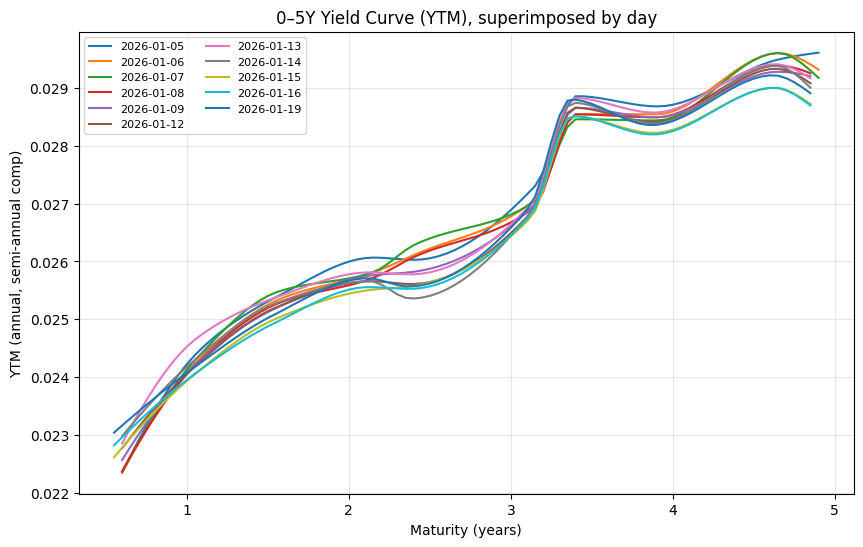

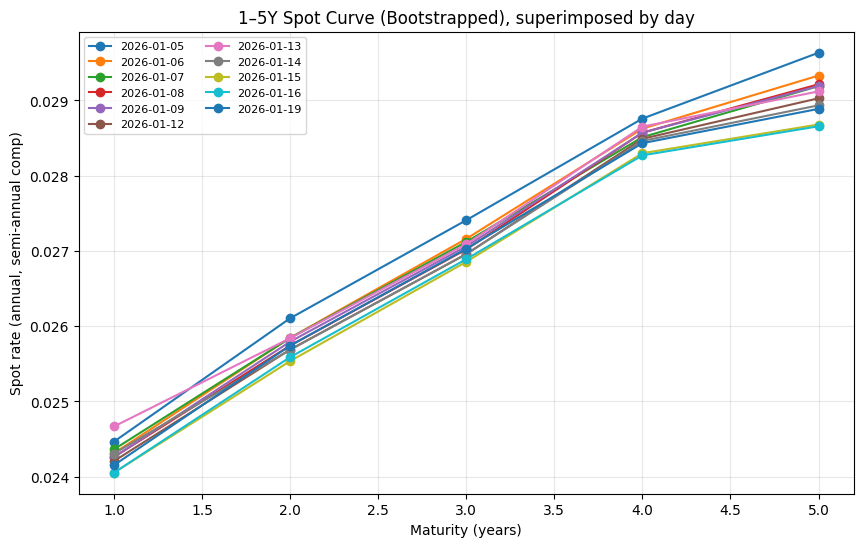

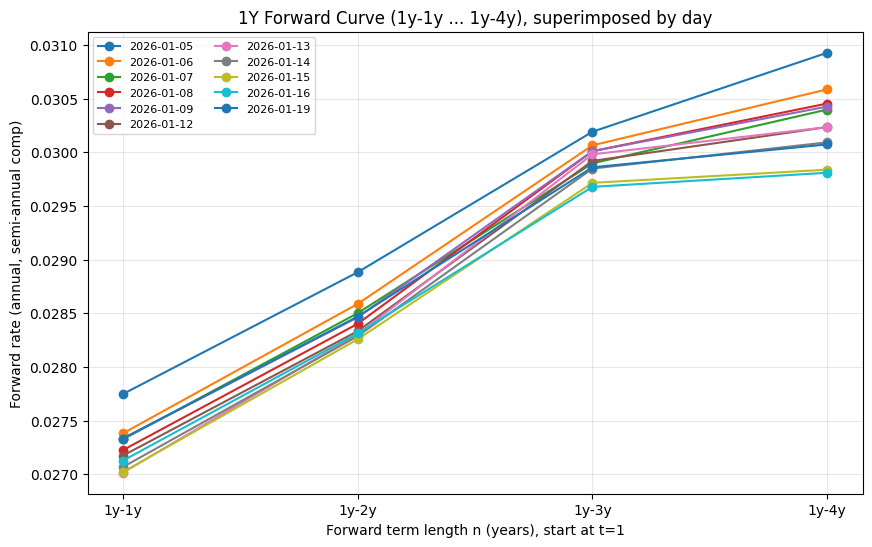

[DONE] 3 plots displayed; CSVs saved: ytm_long.csv / spot_yearly_1to5.csv / forward_1y_curve.csv


In [3]:
from __future__ import annotations

import re
import json
import math
import time
from pathlib import Path
from urllib.parse import urlparse, parse_qs, urlencode, urlunparse

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt


CSV_0_3 = r"C:\Users\daoqi\Desktop\海qin儿\canada_gov_bonds_0_3y.csv"
CSV_3_10 = r"C:\Users\daoqi\Desktop\海qin儿\canada_gov_bonds_3_10y.csv"

DATES = pd.bdate_range("2026-01-05", "2026-01-19")
DATE_FROM = "20260105"
DATE_TO = "20260119"
BASE_DT = pd.Timestamp("2026-01-05")

FINDER_SHORT = "https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=shortterm&yield=&bondtype=2%2C3%2C4%2C16&coupon=&currency=184&rating=&country=19"
FINDER_MID = "https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=midterm&yield=&bondtype=2%2C3%2C4%2C16&coupon=&currency=184&rating=&country=19"

HALF_NODES = np.arange(0.5, 5.0 + 0.5, 0.5)
YEAR_NODES = np.arange(1.0, 5.0 + 1.0, 1.0)

UA = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
    "(KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Connection": "keep-alive",
}

F = 100.0


# Get the script directory (fallback to CWD in notebooks).
def _script_dir() -> Path:
    try:
        return Path(__file__).resolve().parent
    except NameError:
        return Path.cwd()


# Normalize a column name for robust matching.
def _norm_col(s: str) -> str:
    return re.sub(r"\s+", " ", str(s)).strip().lower()


# Normalize and map common column names to standard names.
def normalize_df_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [_norm_col(c) for c in df.columns]
    col_map = {}
    for c in df.columns:
        if c in ["maturity date", "maturity", "mat date"]:
            col_map[c] = "maturity_date"
        elif c in ["coupon"]:
            col_map[c] = "coupon"
        elif c in ["issuer"]:
            col_map[c] = "issuer"
        elif c in ["yield", "ytm"]:
            col_map[c] = "listed_yield"
        elif c in ["bid"]:
            col_map[c] = "bid"
        elif c in ["ask"]:
            col_map[c] = "ask"
        elif "rating" in c:
            col_map[c] = "rating"
        elif "currency" in c:
            col_map[c] = "currency"
    return df.rename(columns=col_map)


# Parse coupon strings like '2.500%' into float values.
def parse_coupon_to_float(x) -> float:
    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace("%", "").replace(",", ".")
    m = re.search(r"[-+]?\d+(\.\d+)?", s)
    return float(m.group(0)) if m else np.nan


# Parse mm/dd/yyyy-like date strings.
def parse_mmddyyyy(x):
    return pd.to_datetime(x, errors="coerce", dayfirst=False)


# Format bond name like 'CAN 2.5 Jun 34'.
def fmt_can_name(coupon_pct: float, maturity_dt: pd.Timestamp) -> str:
    c = float(coupon_pct)
    c_str = f"{c:.3f}".rstrip("0").rstrip(".")
    return f"CAN {c_str} {maturity_dt.strftime('%b')} {maturity_dt.strftime('%y')}"


# Set or overwrite query parameters in a URL.
def _set_query_param(url: str, **params) -> str:
    parts = urlparse(url)
    q = parse_qs(parts.query, keep_blank_values=True)
    for k, v in params.items():
        q[k] = [str(v)]
    new_query = urlencode({k: vs[0] for k, vs in q.items()}, doseq=False)
    return urlunparse(parts._replace(query=new_query))


if "selected10" in globals() and isinstance(globals()["selected10"], pd.DataFrame):
    selected10 = normalize_df_cols(globals()["selected10"].copy())
else:
    df_a = normalize_df_cols(pd.read_csv(CSV_0_3, encoding="utf-8-sig"))
    df_b = normalize_df_cols(pd.read_csv(CSV_3_10, encoding="utf-8-sig"))
    df_all = pd.concat([df_a, df_b], ignore_index=True)
    if "coupon" not in df_all.columns or "maturity_date" not in df_all.columns:
        raise ValueError(f"CSV missing coupon/maturity_date columns. Available columns={list(df_all.columns)}")

    df_all["coupon_pct"] = df_all["coupon"].apply(parse_coupon_to_float)
    df_all["maturity_dt"] = df_all["maturity_date"].apply(parse_mmddyyyy)
    df_all["ttm_years_base"] = (df_all["maturity_dt"] - BASE_DT).dt.days / 365.0
    pool = df_all[(df_all["ttm_years_base"] > 0.1) & (df_all["ttm_years_base"] <= 5.2)].dropna(
        subset=["coupon_pct", "maturity_dt"]
    ).copy()
    pool = pool.reset_index(drop=True)
    if len(pool) < 10:
        raise ValueError(f"Not enough eligible bonds in the 0–5Y range: {len(pool)}")

    picked, used = [], set()
    for node in HALF_NODES:
        target = BASE_DT + pd.Timedelta(days=int(round(node * 365)))
        cand = pool.loc[~pool.index.isin(used)].copy()
        cand["abs_diff_days"] = (cand["maturity_dt"] - target).abs().dt.days
        one = cand.sort_values("abs_diff_days").head(1)
        if one.empty:
            continue
        idx = one.index[0]
        used.add(idx)
        picked.append(one.iloc[0])
    selected10 = pd.DataFrame(picked).reset_index(drop=True)

selected10["coupon_pct"] = selected10.get("coupon_pct", selected10["coupon"].apply(parse_coupon_to_float))
selected10["maturity_dt"] = selected10.get("maturity_dt", selected10["maturity_date"].apply(parse_mmddyyyy))
selected10 = selected10.dropna(subset=["coupon_pct", "maturity_dt"]).copy()
selected10["bond_name"] = selected10.apply(
    lambda r: fmt_can_name(r["coupon_pct"], pd.to_datetime(r["maturity_dt"])), axis=1
)

selected10 = selected10.sort_values("maturity_dt").reset_index(drop=True).iloc[:10].copy()
if len(selected10) < 10:
    raise ValueError(f"selected10 has fewer than 10 bonds: {len(selected10)}")
selected10["node"] = HALF_NODES

node_to_bond = dict(zip(selected10["node"].tolist(), selected10["bond_name"].tolist()))
coupon_map = selected10.set_index("bond_name")["coupon_pct"].to_dict()
maturity_map = selected10.set_index("bond_name")["maturity_dt"].apply(pd.to_datetime).dt.normalize().to_dict()

print(f"[INFO] selected10 fixed: {len(selected10)} bonds; nodes=0.5..5.0")


# Scrape the finder pages (with pagination) to extract snapshot URLs.
def scrape_finder_with_links(base_url: str, max_pages: int = 10) -> pd.DataFrame:
    rows = []
    for p in range(1, max_pages + 1):
        url = base_url if p == 1 else _set_query_param(base_url, p=p)
        html = requests.get(url, headers=UA, timeout=30).text
        soup = BeautifulSoup(html, "html.parser")
        tbody = soup.find("tbody")
        if tbody is None:
            break

        page_rows = 0
        for tr in tbody.find_all("tr"):
            tds = [td.get_text(" ", strip=True) for td in tr.find_all("td")]
            a = tr.find("a", href=True)
            snap = None
            if a and a["href"].startswith("/bonds/"):
                snap = "https://markets.businessinsider.com" + a["href"]
            if len(tds) >= 6 and snap:
                page_rows += 1
                rows.append(
                    {"coupon_raw": tds[2] if len(tds) > 2 else None, "maturity_raw": tds[5] if len(tds) > 5 else None, "snapshot_url": snap}
                )
        if page_rows == 0:
            break
        time.sleep(0.2)

    df = pd.DataFrame(rows).dropna(subset=["snapshot_url"])
    if df.empty:
        raise RuntimeError("Finder scraping failed (blocked or page structure changed).")
    df["coupon_pct"] = df["coupon_raw"].apply(parse_coupon_to_float)
    df["maturity_dt"] = df["maturity_raw"].apply(parse_mmddyyyy).dt.normalize()
    df = df.dropna(subset=["coupon_pct", "maturity_dt"]).drop_duplicates(subset=["coupon_pct", "maturity_dt", "snapshot_url"])
    return df


finder_all = pd.concat(
    [scrape_finder_with_links(FINDER_SHORT), scrape_finder_with_links(FINDER_MID)],
    ignore_index=True,
).drop_duplicates(subset=["coupon_pct", "maturity_dt", "snapshot_url"])

finder_all["key"] = finder_all.apply(
    lambda r: f"{pd.to_datetime(r['maturity_dt']).strftime('%Y-%m-%d')}|{r['coupon_pct']:.4f}", axis=1
)
key2snap = finder_all.drop_duplicates("key").set_index("key")["snapshot_url"].to_dict()

selected10["key"] = selected10.apply(
    lambda r: f"{pd.to_datetime(r['maturity_dt']).normalize().strftime('%Y-%m-%d')}|{r['coupon_pct']:.4f}",
    axis=1,
)
selected10["snapshot_url"] = selected10["key"].map(key2snap)

miss = selected10["snapshot_url"].isna().sum()
print(f"[INFO] snapshot_url matched: {len(selected10) - miss}/{len(selected10)}")
if miss > 0:
    print("[WARN] some bonds are missing snapshot_url -> spot/forward may be incomplete.")


TK_RE = re.compile(r'"TKData"\s*:\s*"([^"]+)"')


# Extract TKData token from a snapshot page.
def extract_tkdata(snapshot_url: str) -> str:
    html = requests.get(snapshot_url, headers=UA, timeout=30).text
    m = TK_RE.search(html)
    if m:
        return m.group(1)
    m2 = re.search(r"TKData[^\"']*[\"']([^\"']+)[\"']", html)
    if m2:
        return m2.group(1)
    raise RuntimeError(f"TKData not found: {snapshot_url}")


# Fetch historical chart data for a bond via the Chart_GetChartData endpoint.
def fetch_chart_data_bond(tkdata: str, from_yyyymmdd: str, to_yyyymmdd: str, referer: str) -> pd.DataFrame:
    url = "https://markets.businessinsider.com/Ajax/Chart_GetChartData"
    params = {"instrumentType": "Bond", "tkData": tkdata, "from": from_yyyymmdd, "to": to_yyyymmdd}
    headers = dict(UA)
    headers["Referer"] = referer
    r = requests.get(url, params=params, headers=headers, timeout=30)
    r.raise_for_status()
    try:
        data = r.json()
    except Exception:
        data = json.loads(r.content.decode("utf-8", errors="ignore"))
    df = pd.DataFrame(data)
    if df.empty:
        return pd.DataFrame(columns=["date", "close"])

    date_col = next((c for c in df.columns if str(c).lower() in ["date", "datetime", "time"]), df.columns[0])
    close_col = next((c for c in df.columns if str(c).lower() in ["close", "last", "value"]), None)
    if close_col is None:
        close_col = next((c for c in df.columns if "close" in str(c).lower()), None)
    if close_col is None:
        raise RuntimeError(f"Close column not found: cols={list(df.columns)}")

    def parse_any_date(x):
        if pd.isna(x):
            return pd.NaT
        s = str(x)
        m = re.search(r"(\d{10,13})", s)
        if m:
            v = int(m.group(1))
            if v > 10_000_000_000:
                return pd.to_datetime(v, unit="ms", utc=True).tz_convert(None)
            return pd.to_datetime(v, unit="s", utc=True).tz_convert(None)
        return pd.to_datetime(s, errors="coerce")

    out = df[[date_col, close_col]].copy()
    out["date"] = out[date_col].apply(parse_any_date).dt.normalize()
    out["close"] = pd.to_numeric(out[close_col], errors="coerce")
    out = out.dropna(subset=["date", "close"]).sort_values("date").reset_index(drop=True)
    out = out.groupby("date", as_index=False)["close"].last().sort_values("date").reset_index(drop=True)
    return out[["date", "close"]]


cache_dir = _script_dir() / "bond_hist_cache"
cache_dir.mkdir(exist_ok=True)

hist_map = {}
for _, r in selected10.iterrows():
    bname = r["bond_name"]
    snap = r.get("snapshot_url", None)
    if not isinstance(snap, str) or not snap.startswith("http"):
        continue

    cache_path = cache_dir / (re.sub(r"[^A-Za-z0-9_\-\.]", "_", bname) + f"_{DATE_FROM}_{DATE_TO}.csv")
    if cache_path.exists():
        dfh = pd.read_csv(cache_path, encoding="utf-8-sig")
        dfh["date"] = pd.to_datetime(dfh["date"]).dt.normalize()
        dfh = dfh.groupby("date", as_index=False)["close"].last().sort_values("date").reset_index(drop=True)
        hist_map[bname] = dfh
        continue

    tk = extract_tkdata(snap)
    dfh = fetch_chart_data_bond(tk, DATE_FROM, DATE_TO, referer=snap)
    dfh.to_csv(cache_path, index=False, encoding="utf-8-sig")
    hist_map[bname] = dfh
    time.sleep(0.2)

print(f"[INFO] hist available: {len(hist_map)}/{len(selected10)} bonds; cache={cache_dir}")

price_panel = pd.DataFrame(index=pd.to_datetime(DATES).normalize())
for bname in selected10["bond_name"]:
    if bname in hist_map and not hist_map[bname].empty:
        tmp = hist_map[bname].copy()
        tmp["date"] = pd.to_datetime(tmp["date"]).dt.normalize()
        tmp = tmp.groupby("date", as_index=False)["close"].last().sort_values("date").reset_index(drop=True)
        s = tmp.set_index("date")["close"].reindex(price_panel.index)
        s = s.ffill().bfill()
    else:
        s = pd.Series(index=price_panel.index, dtype=float)
    price_panel[bname] = s

empty_cols = [c for c in price_panel.columns if price_panel[c].isna().all()]
if empty_cols:
    print(f"[WARN] bonds with no usable prices (all NaN): {len(empty_cols)} -> spot/forward may be empty.")


# Compute bond PV from YTM for semiannual coupons.
def bond_pv_from_ytm(y: float, coupon_rate_annual: float, n_periods: int) -> float:
    if y <= -0.999:
        return np.inf
    c = coupon_rate_annual * F / 2.0
    disc = 1.0 + y / 2.0
    pv_cpn = sum(c / (disc**k) for k in range(1, n_periods + 1))
    pv_pri = F / (disc**n_periods)
    return pv_cpn + pv_pri


# Solve YTM from price using bisection.
def solve_ytm_from_price(price: float, coupon_rate_annual: float, n_periods: int) -> float:
    if n_periods <= 0 or not np.isfinite(price):
        return np.nan
    lo, hi = -0.95, 1.50
    f_lo = bond_pv_from_ytm(lo, coupon_rate_annual, n_periods) - price
    f_hi = bond_pv_from_ytm(hi, coupon_rate_annual, n_periods) - price
    k = 0
    while f_lo * f_hi > 0 and k < 10:
        hi += 1.0
        f_hi = bond_pv_from_ytm(hi, coupon_rate_annual, n_periods) - price
        k += 1
    if f_lo * f_hi > 0:
        return np.nan
    for _ in range(80):
        mid = 0.5 * (lo + hi)
        f_mid = bond_pv_from_ytm(mid, coupon_rate_annual, n_periods) - price
        if abs(f_mid) < 1e-8:
            return mid
        if f_lo * f_mid <= 0:
            hi, f_hi = mid, f_mid
        else:
            lo, f_lo = mid, f_mid
    return 0.5 * (lo + hi)


ytm_rows = []
for d in price_panel.index:
    for bname in selected10["bond_name"]:
        p = float(price_panel.loc[d, bname]) if pd.notna(price_panel.loc[d, bname]) else np.nan
        mat = maturity_map.get(bname, pd.NaT)
        if pd.isna(mat) or not np.isfinite(p):
            continue
        ttm = (mat - d).days / 365.0
        n = int(round(ttm * 2))
        y = solve_ytm_from_price(p, float(coupon_map[bname]) / 100.0, n)
        ytm_rows.append({"date": d, "bond_name": bname, "ttm_years": ttm, "price": p, "ytm": y})

ytm_df = pd.DataFrame(ytm_rows, columns=["date", "bond_name", "ttm_years", "price", "ytm"]).dropna(subset=["ytm"])
ytm_df.to_csv(_script_dir() / "ytm_long.csv", index=False, encoding="utf-8-sig")


# Interpolate a curve on a grid (PCHIP if available, else linear).
def interp_curve(x, y, grid):
    try:
        from scipy.interpolate import PchipInterpolator
        f = PchipInterpolator(x, y, extrapolate=False)
        return f(grid)
    except Exception:
        return np.interp(grid, x, y, left=np.nan, right=np.nan)


grid = np.linspace(0.5, 5.0, 91)
fig1, ax1 = plt.subplots(figsize=(10, 6))
if not ytm_df.empty:
    for d in sorted(ytm_df["date"].unique()):
        sub = ytm_df[ytm_df["date"] == d].sort_values("ttm_years")
        sub = sub[(sub["ttm_years"] > 0.1) & (sub["ttm_years"] <= 5.0)]
        if len(sub) < 3:
            continue
        yy = interp_curve(sub["ttm_years"].values, sub["ytm"].values, grid)
        ax1.plot(grid, yy, label=str(pd.to_datetime(d).date()))
else:
    ax1.text(0.5, 0.5, "No YTM data available", transform=ax1.transAxes, ha="center", va="center")

ax1.set_title("0–5Y Yield Curve (YTM), superimposed by day")
ax1.set_xlabel("Maturity (years)")
ax1.set_ylabel("YTM (annual, semi-annual comp)")
ax1.grid(True, alpha=0.3)
h1, l1 = ax1.get_legend_handles_labels()
if len(h1) > 0:
    ax1.legend(ncol=2, fontsize=8)
plt.show()


# Bootstrap discount factors from bond prices for semiannual nodes.
def bootstrap_discount_factors_for_day(day_prices: dict[str, float]) -> dict[float, float]:
    DF = {}
    for t in HALF_NODES:
        bname = node_to_bond[t]
        if bname not in day_prices or not np.isfinite(day_prices[bname]):
            return {}
        price = float(day_prices[bname])
        c_rate = float(coupon_map[bname]) / 100.0
        c = c_rate * F / 2.0
        n = int(round(t * 2))
        if n == 1:
            df_t = price / (F + c)
        else:
            pv_known = 0.0
            for k in range(1, n):
                tk = 0.5 * k
                if tk not in DF:
                    return {}
                pv_known += c * DF[tk]
            df_t = (price - pv_known) / (F + c)
        if (not np.isfinite(df_t)) or df_t <= 0:
            return {}
        DF[t] = df_t
    return DF


# Convert a discount factor to a semiannual-compounded spot rate.
def df_to_spot(df: float, t: float) -> float:
    return 2.0 * (df ** (-1.0 / (2.0 * t)) - 1.0)


spot_rows, df_rows = [], []
for d in price_panel.index:
    day_prices = {b: float(price_panel.loc[d, b]) for b in selected10["bond_name"] if pd.notna(price_panel.loc[d, b])}
    DF = bootstrap_discount_factors_for_day(day_prices)
    if not DF:
        continue
    for t, dfv in DF.items():
        df_rows.append({"date": d, "t_years": t, "df": dfv})
    for t in YEAR_NODES:
        spot_rows.append({"date": d, "t_years": t, "spot": df_to_spot(DF[t], t)})

spot_df = pd.DataFrame(spot_rows, columns=["date", "t_years", "spot"])
spot_df.to_csv(_script_dir() / "spot_yearly_1to5.csv", index=False, encoding="utf-8-sig")

fig2, ax2 = plt.subplots(figsize=(10, 6))
if not spot_df.empty:
    for d in sorted(spot_df["date"].unique()):
        sub = spot_df[spot_df["date"] == d].sort_values("t_years")
        ax2.plot(sub["t_years"], sub["spot"], marker="o", label=str(pd.to_datetime(d).date()))
else:
    ax2.text(0.5, 0.5, "No spot curve data (check prices/snapshot matching)", transform=ax2.transAxes, ha="center", va="center")

ax2.set_title("1–5Y Spot Curve (Bootstrapped), superimposed by day")
ax2.set_xlabel("Maturity (years)")
ax2.set_ylabel("Spot rate (annual, semi-annual comp)")
ax2.grid(True, alpha=0.3)
h2, l2 = ax2.get_legend_handles_labels()
if len(h2) > 0:
    ax2.legend(ncol=2, fontsize=8)
plt.show()


# Compute a 1Y forward rate from discount factors.
def forward_1y_from_df(df1: float, df_end: float, n_years: int) -> float:
    return 2.0 * ((df1 / df_end) ** (1.0 / (2.0 * n_years)) - 1.0)


df_df = pd.DataFrame(df_rows, columns=["date", "t_years", "df"])
fwd_rows = []
if not df_df.empty:
    for d in sorted(df_df["date"].unique()):
        sub = df_df[df_df["date"] == d].set_index("t_years")["df"].to_dict()
        if not all(t in sub for t in [1.0, 2.0, 3.0, 4.0, 5.0]):
            continue
        df1 = sub[1.0]
        for n in [1, 2, 3, 4]:
            f = forward_1y_from_df(df1, sub[1.0 + n], n_years=n)
            fwd_rows.append({"date": d, "tenor": f"1y-{n}y", "n_years": n, "forward": f})

fwd_df = pd.DataFrame(fwd_rows, columns=["date", "tenor", "n_years", "forward"])
fwd_df.to_csv(_script_dir() / "forward_1y_curve.csv", index=False, encoding="utf-8-sig")

fig3, ax3 = plt.subplots(figsize=(10, 6))
if not fwd_df.empty:
    for d in sorted(fwd_df["date"].unique()):
        sub = fwd_df[fwd_df["date"] == d].sort_values("n_years")
        ax3.plot(sub["n_years"], sub["forward"], marker="o", label=str(pd.to_datetime(d).date()))
else:
    ax3.text(0.5, 0.5, "No forward curve data (needs spot DF at 1..5y)", transform=ax3.transAxes, ha="center", va="center")

ax3.set_title("1Y Forward Curve (1y-1y ... 1y-4y), superimposed by day")
ax3.set_xlabel("Forward term length n (years), start at t=1")
ax3.set_ylabel("Forward rate (annual, semi-annual comp)")
ax3.set_xticks([1, 2, 3, 4])
ax3.set_xticklabels(["1y-1y", "1y-2y", "1y-3y", "1y-4y"])
ax3.grid(True, alpha=0.3)
h3, l3 = ax3.get_legend_handles_labels()
if len(h3) > 0:
    ax3.legend(ncol=2, fontsize=8)
plt.show()

print("[DONE] 3 plots displayed; CSVs saved: ytm_long.csv / spot_yearly_1to5.csv / forward_1y_curve.csv")


（4）Empirical Questions 5

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path

assert "ytm_df" in globals() and isinstance(ytm_df, pd.DataFrame), "Please run Q4 first to generate ytm_df."
assert "fwd_df" in globals() and isinstance(fwd_df, pd.DataFrame), "Please run Q4 first to generate fwd_df."

dates = pd.to_datetime(pd.bdate_range("2026-01-05", "2026-01-19")).normalize()

# Get interpolated YTM points with flat extrapolation at boundaries.
def ytm_points_for_day_with_flat_extrap(sub: pd.DataFrame, targets=(1, 2, 3, 4, 5)):
    sub = sub.sort_values("ttm_years").copy()
    sub = sub.dropna(subset=["ttm_years", "ytm"])
    sub = sub[(sub["ttm_years"] > 0.05) & (sub["ttm_years"] <= 5.2)]
    if len(sub) < 3:
        return {t: np.nan for t in targets}

    tmp = sub[["ttm_years", "ytm"]].copy()
    tmp["ttm_years"] = tmp["ttm_years"].astype(float)
    tmp["ytm"] = tmp["ytm"].astype(float)

    tmp = tmp.groupby("ttm_years", as_index=False)["ytm"].last().sort_values("ttm_years")
    x = tmp["ttm_years"].values
    y = tmp["ytm"].values
    x_min, x_max = float(x[0]), float(x[-1])
    y_min, y_max = float(y[0]), float(y[-1])

    def eval_one(t):
        t = float(t)
        if t <= x_min:
            return y_min
        if t >= x_max:
            return y_max
        try:
            from scipy.interpolate import PchipInterpolator
            f = PchipInterpolator(x, y, extrapolate=False)
            return float(f(t))
        except Exception:
            return float(np.interp(t, x, y))

    return {t: eval_one(t) for t in targets}


yield_panel = pd.DataFrame(index=dates, columns=[f"Y{i}" for i in range(1, 6)], dtype=float)
for d in dates:
    sub = ytm_df[ytm_df["date"] == d]
    pts = ytm_points_for_day_with_flat_extrap(sub, targets=(1, 2, 3, 4, 5))
    for i in range(1, 6):
        yield_panel.loc[d, f"Y{i}"] = pts[i]

yield_panel = yield_panel.ffill().bfill()

fwd_panel = (
    fwd_df.copy()
    .assign(date=lambda x: pd.to_datetime(x["date"]).dt.normalize())
    .pivot_table(index="date", columns="tenor", values="forward", aggfunc="last")
    .reindex(dates)
)

need_fwd_cols = ["1y-1y", "1y-2y", "1y-3y", "1y-4y"]
for c in need_fwd_cols:
    if c not in fwd_panel.columns:
        fwd_panel[c] = np.nan
fwd_panel = fwd_panel[need_fwd_cols].astype(float).ffill().bfill()

# Compute daily log-returns for a rate panel.
def log_return_panel(rate_panel: pd.DataFrame) -> pd.DataFrame:
    rp = rate_panel.copy()
    rp = rp.where(rp > 0, np.nan)
    lr = np.log(rp.shift(-1) / rp)
    return lr.iloc[:-1]


yield_lr = log_return_panel(yield_panel)
fwd_lr = log_return_panel(fwd_panel)

yield_cov = yield_lr.cov(min_periods=5, ddof=1)
fwd_cov = fwd_lr.cov(min_periods=5, ddof=1)

print("=== Q5 A: Daily log-returns of Yields (1Y..5Y) [9 x 5] ===")
display(yield_lr)

print("\n=== Q5 A: Covariance Matrix of Yield log-returns [5 x 5] ===")
display(yield_cov)

print("\n=== Q5 B: Daily log-returns of Forward rates (1y-1y..1y-4y) [9 x 4] ===")
display(fwd_lr)

print("\n=== Q5 B: Covariance Matrix of Forward log-returns [4 x 4] ===")
display(fwd_cov)

out_dir = Path.cwd()
yield_cov.to_csv(out_dir / "cov_yield_logret.csv", encoding="utf-8-sig")
fwd_cov.to_csv(out_dir / "cov_forward_logret.csv", encoding="utf-8-sig")
print(f"\n[INFO] saved: {out_dir/'cov_yield_logret.csv'} , {out_dir/'cov_forward_logret.csv'}")


=== Q5 A: Daily log-returns of Yields (1Y..5Y) [9 x 5] ===


,Y1,Y2,Y3,Y4,Y5
2026-01-05,-0.005974,-0.012045,-0.004114,-0.004032,-0.010219
2026-01-06,0.002020,0.000812,0.001256,-0.003527,-0.004746
2026-01-07,-0.003214,-0.004627,-0.005124,0.001524,0.000792
2026-01-08,0.000997,0.003699,-0.002392,-0.000117,-0.000792
2026-01-09,-0.000863,-0.002278,-0.004562,-0.002332,-0.005561
2026-01-12,0.019421,0.005972,0.005654,0.005579,0.003181
2026-01-13,-0.014366,-0.005656,-0.007447,-0.006151,-0.006371
2026-01-14,-0.010119,-0.007434,-0.000408,-0.006140,-0.008816
2026-01-15,0.000734,0.002725,0.000696,-0.000802,-0.000805
2026-01-16,0.005023,0.006159,0.005032,0.006126,0.008023



=== Q5 A: Covariance Matrix of Yield log-returns [5 x 5] ===


,Y1,Y2,Y3,Y4,Y5
Y1,0.000084,0.000043,0.000032,0.000033,0.000035
Y2,0.000043,0.000038,0.000019,0.000020,0.000029
Y3,0.000032,0.000019,0.000019,0.000013,0.000015
Y4,0.000033,0.000020,0.000013,0.000019,0.000023
Y5,0.000035,0.000029,0.000015,0.000023,0.000032



=== Q5 B: Daily log-returns of Forward rates (1y-1y..1y-4y) [9 x 4] ===


tenor,1y-1y,1y-2y,1y-3y,1y-4y
2026-01-05,-0.013299,-0.010269,-0.004209,-0.011086
2026-01-06,-0.002036,-0.003025,-0.005600,-0.006176
2026-01-07,-0.003673,-0.003477,0.003785,0.001844
2026-01-08,0.003901,0.002111,0.000016,-0.000939
2026-01-09,-0.005794,-0.004520,-0.003038,-0.006293
2026-01-12,-0.005848,-0.001038,0.002059,-0.000019
2026-01-13,0.001934,-0.000625,-0.004438,-0.004697
2026-01-14,-0.001729,-0.001022,-0.004476,-0.008507
2026-01-15,0.003929,0.001933,-0.001256,-0.000966
2026-01-16,0.007586,0.005522,0.006121,0.008823



=== Q5 B: Covariance Matrix of Forward log-returns [4 x 4] ===


tenor,1y-1y,1y-2y,1y-3y,1y-4y
tenor,,,,
1y-1y,0.000037,0.000025,0.000009,0.000024
1y-2y,0.000025,0.000019,0.000009,0.000019
1y-3y,0.000009,0.000009,0.000016,0.000021
1y-4y,0.000024,0.000019,0.000021,0.000033



[INFO] saved: c:\Users\daoqi\Desktop\海qin儿\cov_yield_logret.csv , c:\Users\daoqi\Desktop\海qin儿\cov_forward_logret.csv


（5）Empirical Questions 6

In [6]:
import numpy as np
import pandas as pd

assert "yield_cov" in globals() and isinstance(yield_cov, pd.DataFrame), "Please run Q5 first to generate yield_cov."
assert "fwd_cov" in globals() and isinstance(fwd_cov, pd.DataFrame), "Please run Q5 first to generate fwd_cov."

# Generate an eigen-decomposition report for a covariance matrix.
def eig_report(cov_df: pd.DataFrame, name: str):
    A = cov_df.copy()
    A = A.fillna(0.0)
    A = (A + A.T) / 2.0

    w, v = np.linalg.eigh(A.values)

    idx = np.argsort(w)[::-1]
    w = w[idx]
    v = v[:, idx]

    w_sum = float(np.sum(w)) if np.sum(w) != 0 else np.nan
    var_ratio = w / w_sum if np.isfinite(w_sum) else np.full_like(w, np.nan)
    cum_ratio = np.cumsum(var_ratio) if np.all(np.isfinite(var_ratio)) else np.full_like(w, np.nan)

    ev_table = pd.DataFrame(
        {"eigenvalue": w, "var_ratio": var_ratio, "cum_var_ratio": cum_ratio},
        index=[f"PC{i}" for i in range(1, len(w) + 1)],
    )

    loadings = pd.DataFrame(
        v,
        index=A.index,
        columns=[f"PC{i}" for i in range(1, v.shape[1] + 1)],
    )

    print(f"\n==================== {name} ====================")
    print("Eigenvalues & explained variance:")
    display(ev_table)

    print("\nEigenvectors (loadings): columns are PCs, rows are maturities/tenors")
    display(loadings)

    pc1_loading = loadings["PC1"]
    same_sign = (np.all(pc1_loading >= 0) or np.all(pc1_loading <= 0))
    mode = "approximately a parallel shift (Level factor)" if same_sign else "not a pure parallel shift (more like slope/shape mixture)"
    explained = float(ev_table.loc["PC1", "var_ratio"]) if "PC1" in ev_table.index else np.nan


eig_report(yield_cov, "Yield log-return covariance (Y1..Y5)")
eig_report(fwd_cov, "Forward log-return covariance (1y-1y..1y-4y)")



==================== Yield log-return covariance (Y1..Y5) ====================
Eigenvalues & explained variance:


,eigenvalue,var_ratio,cum_var_ratio
PC1,1.594109e-04,0.829559,0.829559
PC2,1.839204e-05,0.095710,0.925269
PC3,8.555268e-06,0.044521,0.969790
PC4,5.654889e-06,0.029427,0.999217
PC5,1.503893e-07,0.000783,1.000000



Eigenvectors (loadings): columns are PCs, rows are maturities/tenors


,PC1,PC2,PC3,PC4,PC5
Y1,-0.693553,-0.619780,0.187036,-0.246327,0.197983
Y2,-0.436101,0.369738,-0.666009,-0.408855,-0.249760
Y3,-0.286835,-0.153344,-0.406056,0.853077,-0.039861
Y4,-0.314393,0.210186,0.517477,0.143148,-0.754126
Y5,-0.384295,0.641463,0.297970,0.154688,0.572825



==================== Forward log-return covariance (1y-1y..1y-4y) ====================
Eigenvalues & explained variance:


,eigenvalue,var_ratio,cum_var_ratio
PC1,8.371788e-05,0.797053,0.797053
PC2,1.983764e-05,0.188868,0.985921
PC3,1.061175e-06,0.010103,0.996024
PC4,4.176126e-07,0.003976,1.000000



Eigenvectors (loadings): columns are PCs, rows are maturities/tenors


,PC1,PC2,PC3,PC4
tenor,,,,
1y-1y,-0.598446,-0.592535,-0.415631,-0.343533
1y-2y,-0.444075,-0.262054,0.826603,0.225506
1y-3y,-0.323075,0.591760,0.207410,-0.708818
1y-4y,-0.583338,0.479635,-0.317740,0.573332
